In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import datetime 
from geopy import distance
import folium
from folium.plugins import MarkerCluster
from folium.features import GeoJsonTooltip
from branca.colormap import LinearColormap
from collections import Counter
import json
from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import shape

In [3]:
data_types = {
    "rideable_type": "category", 
    "start_station_name": "category", 
    "end_station_name": "category", 
    "member_casual":"category",
    # "ride_id":"uint32",
    "time_of_day":"category",
    "trip_type":"category"}


In [4]:
rides_maryland = pd.read_csv("bikes_clean.csv", dtype = data_types, parse_dates= ["started_at", "ended_at"], low_memory=False)


In [5]:
with open ("Maryland_Physical_Boundaries_-_County_Boundaries_(Detailed).geojson") as i:
    maryland = json.loads(i.read())

features = maryland["features"]

#GDF
maryland_gdf = gpd.GeoDataFrame(
    pd.DataFrame([feature['properties'] for feature in features]),  # Extract properties as attributes
    geometry=[shape(feature['geometry']) for feature in features],  # Convert geometries
    crs="EPSG:4326")

# join gdf and filter maryland rides

In [7]:
# Create a GeoDataFrame for the start stations
geometry = [Point(xy) for xy in zip(rides_maryland['start_lng'], rides_maryland['start_lat'])]
bikes_gdf = gpd.GeoDataFrame(rides_maryland, geometry=geometry, crs="EPSG:4326")

# # Perform spatial join with the maryland gdf
bikes_maryland_join = gpd.sjoin(bikes_gdf, maryland_gdf, how="left", predicate="within")

In [8]:
rides_maryland = bikes_maryland_join.dropna(subset="COUNTY")


In [10]:
rides_maryland = rides_maryland.copy()

In [11]:
rides_maryland['year'] = rides_maryland['started_at'].dt.year
rides_maryland['dow'] = rides_maryland['started_at'].dt.dayofweek
rides_maryland["weekday"] = rides_maryland["started_at"].dt.day_name()

In [12]:
rides_maryland = rides_maryland.drop(columns= ['index_right','OBJECTID','DISTRICT', 'COUNTY_FIP', 'COUNTYNUM','CREATION_D', 'LAST_UPDAT'])

In [14]:
# # Count rides per county
rides_per_county = rides_maryland.groupby("COUNTY").size().reset_index(name="ride_count")  
rides_per_county

,COUNTY,ride_count
0,Montgomery,168967
1,Prince George's,74195


In [29]:
# Convert 'weekday' to a categorical type with the correct order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
rides_maryland["weekday"] = pd.Categorical(rides_maryland["weekday"], categories=weekday_order, ordered=True)


In [30]:
rides_maryland.to_csv("cabi_maryland.csv", index=False)

# filtering per year

In [31]:
year_2021= rides_maryland[rides_maryland["year"]==2021]
year_2022= rides_maryland[rides_maryland["year"]==2022]
rides_maryland_2023= rides_maryland[rides_maryland["year"]==2023]

In [32]:
rides_maryland["year"].value_counts()

year
2023    98071
2021    72587
2022    72504
Name: count, dtype: int64

# filtering unique stations (classic and docked ebikes) from undocked e-bikes 

In [33]:
# unique_station_coordinates.groupby("start_station_name")["start_lat"].mean()
avg_lat_per_station = rides_maryland.groupby("start_station_name", as_index=False, observed=False)["start_lat"].mean()
avg_lng_per_station = rides_maryland.groupby("start_station_name", as_index=False, observed = False)["start_lng"].mean()

maryland_unique_bike_stations = avg_lat_per_station.merge(avg_lng_per_station)
maryland_unique_bike_stations = maryland_unique_bike_stations.dropna(subset="start_lat")
maryland_unique_bike_stations

,start_station_name,start_lat,start_lng
5,10th & Monroe St NE,38.973495,-77.020706
8,10th & U St NW,38.983053,-76.998549
14,11th & C St SE,39.000126,-77.079726
15,11th & Clifton St NW,39.012635,-77.066359
21,11th & O St NW,39.012635,-77.066359
...,...,...,...
850,Wisconsin Ave & Ingomar St NW,39.012635,-77.066359
851,Wisconsin Ave & Newark St NW,38.931240,-76.951919
853,Wisconsin Ave & Rodman St NW,38.989793,-77.028654
855,Woodglen Dr & Executive Blvd,39.043182,-77.113494


In [34]:
rides_maryland_2023["rideable_type"].value_counts()

rideable_type
electric_bike    48641
classic_bike     46467
docked_bike       2963
Name: count, dtype: int64

In [40]:
undocked_bikes = rides_maryland_2023[rides_maryland_2023["rideable_type"] == "electric_bike" ]

In [45]:
# Count rides per weekday
rides_per_day = undocked_bikes["weekday"].value_counts().sort_index()

# Calculate average rides per weekday
# nunique() gives the number of unique dates in the dataset.
# Dividing by nunique() provides the average rides per weekday.
average_rides = rides_per_day /undocked_bikes["started_at"].dt.date.nunique()
print("Average rides in Maryland for each day of the week in 2023",average_rides)

Average rides in Maryland for each day of the week in 2023 weekday
Monday       18.057534
Tuesday      19.668493
Wednesday    19.419178
Thursday     19.512329
Friday       19.117808
Saturday     19.057534
Sunday       18.430137
Name: count, dtype: float64


<Axes: xlabel='weekday'>

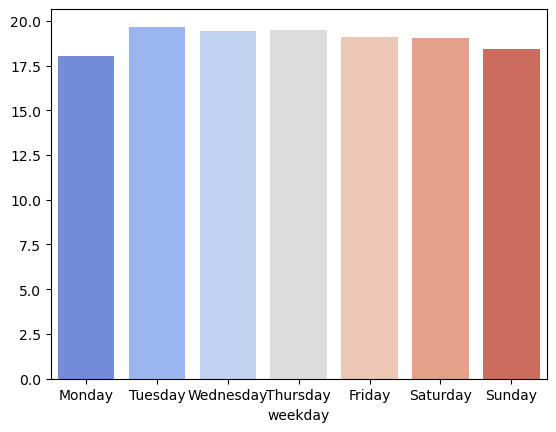

In [48]:
sns.barplot(x=average_rides.index, y=average_rides.values, palette="coolwarm", hue=average_rides.index)

undocked bikes shows rides, not stations. can think of a timelapse per hour to see how the bikes are placed at a given time. Mapping all the undocled ebikes in a year at once will give the impression there are lot more in circulation than they actually are